# Atividade Aula 3

Este notebook implementa uma **Regressão Logística** com **PyTorch** sobre o dataset *Student Exam Performance Prediction* (Kaggle).

**Instruções rápidas:**
- Baixe o dataset do Kaggle e coloque o CSV em `./data/student_exam.csv`.
- Se preferir, adapte o caminho no código abaixo.
- O notebook faz pré-processamento (one-hot em categóricas, normalização), divide treino/test e treina um modelo de Regressão Logística escrito em PyTorch.

> Referência do dataset (Kaggle): https://www.kaggle.com/datasets/mrsimple07/student-exam-performance-prediction


In [7]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import kagglehub
from kagglehub import KaggleDatasetAdapter

print('Versões:', pd.__version__, np.__version__, torch.__version__)

Versões: 2.2.2 2.0.2 2.8.0+cu126


In [8]:
file_path = "student_exam_data.csv"

df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "mrsimple07/student-exam-performance-prediction",
  file_path,
)

df.head()

/tmp/ipython-input-1414832167.py:3: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


Using Colab cache for faster access to the 'student-exam-performance-prediction' dataset.


,Study Hours,Previous Exam Score,Pass/Fail
0,4.370861,81.889703,0
1,9.556429,72.165782,1
2,7.587945,58.571657,0
3,6.387926,88.827701,1
4,2.404168,81.083870,0


In [9]:
if any(c.lower() in ['passed','pass','final_result','result'] for c in df.columns):
    for c in df.columns:
        if c.lower() in ['passed','pass','final_result','result']:
            target_col = c
            break
    y_raw = df[target_col]
    print('Coluna alvo encontrada:', target_col)
else:
    score_cols = [c for c in df.columns if 'score' in c.lower()]
    if len(score_cols) >= 1:
        df['avg_score'] = df[score_cols].mean(axis=1)
        y_raw = (df['avg_score'] >= 50).astype(int)  # 1 = aprovado, 0 = reprovado
        print('Criada coluna alvo a partir da média (>=50 -> aprovado). Colunas de nota encontradas:', score_cols)
    else:
        if 'hours' in df.columns or 'study_hours' in df.columns:
            col = 'hours' if 'hours' in df.columns else 'study_hours'
            y_raw = (df[col] >= df[col].median()).astype(int)
            print('Criada coluna alvo a partir das horas de estudo (>= mediana -> 1).')
        else:
            raise ValueError('Não foi possível criar uma coluna alvo automaticamente. Ajuste o notebook para seu CSV.')

y = y_raw.astype(int)
print('\nProporção de classes:')
print(y.value_counts(normalize=True))

Criada coluna alvo a partir da média (>=50 -> aprovado). Colunas de nota encontradas: ['Previous Exam Score']

Proporção de classes:
avg_score
1    0.818
0    0.182
Name: proportion, dtype: float64


In [10]:
cols_drop = []
possible_id = [c for c in df.columns if 'id' in c.lower()]
cols_drop += possible_id

X = df.drop(columns=cols_drop)
for c in [ 'passed','pass','final_result','result','avg_score']:
    if c in X.columns:
        X = X.drop(columns=[c])

if 'avg_score' in X.columns and 'avg_score' not in cols_drop:
    X = X.drop(columns=['avg_score'])

num_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object','category']).columns.tolist()
print('Numéricas:', num_cols)
print('Categóricas:', cat_cols)

max_levels = 20
use_cat = [c for c in cat_cols if X[c].nunique() <= max_levels]
if len(use_cat) < len(cat_cols):
    print('Ignorando colunas categóricas com muitos níveis:', set(cat_cols)-set(use_cat))

X_proc = pd.get_dummies(X[num_cols + use_cat], drop_first=True)
print('\nShape após one-hot:', X_proc.shape)

scaler = StandardScaler()
X_arr = scaler.fit_transform(X_proc)

X_train, X_test, y_train, y_test = train_test_split(X_arr, y.values, test_size=0.2, random_state=42, stratify=y)
print('\nShapes: X_train', X_train.shape, 'X_test', X_test.shape)

Numéricas: ['Study Hours', 'Previous Exam Score', 'Pass/Fail']
Categóricas: []

Shape após one-hot: (500, 3)

Shapes: X_train (400, 3) X_test (100, 3)


In [11]:
X_train_t = torch.tensor(X_train, dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_train_t = torch.tensor(y_train.reshape(-1,1), dtype=torch.float32)
y_test_t = torch.tensor(y_test.reshape(-1,1), dtype=torch.float32)

train_ds = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)

class LogisticRegressionModel(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.linear = nn.Linear(n_features, 1)
    def forward(self, x):
        return torch.sigmoid(self.linear(x))

model = LogisticRegressionModel(X_train_t.shape[1])
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

print(model)

LogisticRegressionModel(
  (linear): Linear(in_features=3, out_features=1, bias=True)
)


Epoch   1 - Loss: 0.6662
Epoch  10 - Loss: 0.2633
Epoch  20 - Loss: 0.2147
Epoch  30 - Loss: 0.1919
Epoch  40 - Loss: 0.1767
Epoch  50 - Loss: 0.1659
Epoch  60 - Loss: 0.1575
Epoch  70 - Loss: 0.1503
Epoch  80 - Loss: 0.1445
Epoch  90 - Loss: 0.1393
Epoch 100 - Loss: 0.1351


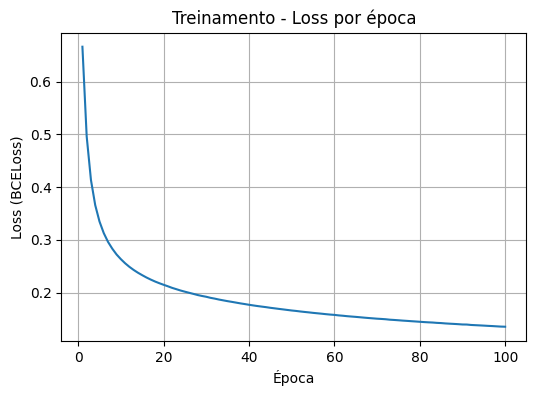

In [12]:
# Treinamento
n_epochs = 100
loss_history = []
for epoch in range(1, n_epochs+1):
    model.train()
    running_loss = 0.0
    for xb, yb in train_loader:
        pred = model(xb)
        loss = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    loss_history.append(epoch_loss)
    if epoch % 10 == 0 or epoch == 1:
        print(f'Epoch {epoch:3d} - Loss: {epoch_loss:.4f}')

# Plot da perda
plt.figure(figsize=(6,4))
plt.plot(range(1, n_epochs+1), loss_history)
plt.xlabel('Época')
plt.ylabel('Loss (BCELoss)')
plt.title('Treinamento - Loss por época')
plt.grid(True)
plt.show()

In [13]:
# Avaliação no conjunto de teste
model.eval()
with torch.no_grad():
    y_prob_test = model(X_test_t).numpy().ravel()
    y_pred_test = (y_prob_test >= 0.5).astype(int)

print('Accuracy:', accuracy_score(y_test, y_pred_test))
print('\nClassification report:')
print(classification_report(y_test, y_pred_test, digits=4))
try:
    auc = roc_auc_score(y_test, y_prob_test)
    print('ROC AUC:', auc)
except Exception as e:
    print('ROC AUC não pôde ser calculado:', e)

Accuracy: 0.97

Classification report:
              precision    recall  f1-score   support

           0     0.8571    1.0000    0.9231        18
           1     1.0000    0.9634    0.9814        82

    accuracy                         0.9700       100
   macro avg     0.9286    0.9817    0.9522       100
weighted avg     0.9743    0.9700    0.9709       100

ROC AUC: 0.9993224932249323
